In [13]:
import sys
import os
import numpy as np
from time import time
sys.path.append(os.path.abspath("../../mathematical_models"))
from mathematical_models.s_on_f import ScalarOnFunctionModel
from mathematical_models.f_on_f import FunctionOnFunctionModel
from mathematical_models.s_on_s import ScalarOnScalarModel

sys.path.append(os.path.abspath("../../optimizers"))
from optimizers.nbdo import NBDO


sys.path.append(os.path.abspath("../../utilities"))
from utilities.plotting.plot_fun import subplot_results

### Settings

In [14]:
start_time = time()
N = 136 # runs
Kx = [[15]]
epochs = 100
order = 2
s_on_s_model = ScalarOnScalarModel(Kx=Kx[0], order=order)
optimizer_s_on_s = NBDO(model=s_on_s_model, latent_dim=4)
optimizer_s_on_s.compute_train_set(num_designs=1_000, runs=N, type="random")
history = optimizer_s_on_s.fit(epochs=epochs, patience=5, batch_size=2**8)
best_cr, best_des = optimizer_s_on_s.optimize()
end_time = time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

Epoch 1/100


2025-08-03 11:54:54.890940: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
4/4 [==============================] - 5s 460ms/step - loss: 38392140.0000 - val_loss: 230239.9219
Epoch 2/100
4/4 [==============================] - 2s 348ms/step - loss: 77017.1875 - val_loss: 587.1858
Epoch 3/100
4/4 [==============================] - 1s 342ms/step - loss: 540.6711 - val_loss: 456.9918
Epoch 4/100
4/4 [==============================] - 1s 336ms/step - loss: 433.0406 - val_loss: 384.6909
Epoch 5/100
4/4 [==============================] - 1s 306ms/step - loss: 367.4070 - val_loss: 332.0948
Epoch 6/100
4/4 [==============================] - 1s 304ms/step - loss: 314.2935 - val_loss: 242.6597
Epoch 7/100
4/4 [==============================] - 1s 299ms/step - loss: 219.1419 - val_loss: 176.0122
Epoch 8/100
4/4 [==============================] - 1s 300ms/step - loss: 163.092

In [16]:
import pandas as pd

# Assuming best_des is already defined and has shape (136, 15)
columns = [f'x{i}' for i in range(1, 16)]
best_des_df = pd.DataFrame(best_des, columns=columns)
best_des_df.to_csv('./design7.csv', index=False)

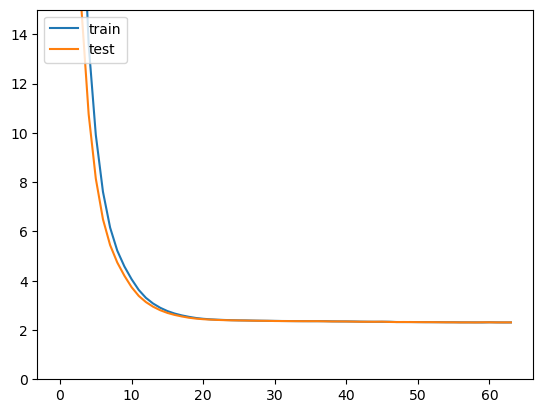

In [46]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0, 15)
plt.show()

### LOOP

In [3]:
# Parameters
epochs = 100
order = 2
batch_size = 2**8
patience = 5
latent_dim = 4

# Define experiments
experiments = [
    {"Kx": [15], "N_list": [136, 142, 160]},
    {"Kx": [20], "N_list": [231, 237, 250]},
]

# Run loop
for exp in experiments:
    Kx = exp["Kx"]
    for N in exp["N_list"]:
        print(f"\nRunning for Kx = {Kx}, N = {N}...")
        start_time = time()

        model = ScalarOnScalarModel(Kx=Kx, order=order)
        optimizer = NBDO(model=model, latent_dim=latent_dim)

        optimizer.compute_train_set(num_designs=1_000, runs=N, type="random")
        history = optimizer.fit(epochs=epochs, patience=patience, batch_size=batch_size)
        best_cr, best_des = optimizer.optimize()

        end_time = time()
        print(f"Finished: Kx={Kx}, N={N}")
        print(f"Time taken: {end_time - start_time:.2f} seconds")
        print(f"Best criterion: {best_cr}\n")


Running for Kx = [15], N = 136...
Epoch 1/100


2025-08-02 22:31:01.029499: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
4/4 [==============================] - 5s 487ms/step - loss: 40820848.0000 - val_loss: 2234.3369
Epoch 2/100
4/4 [==============================] - 1s 314ms/step - loss: 1507.4650 - val_loss: 942.7389
Epoch 3/100
4/4 [==============================] - 1s 346ms/step - loss: 856.7014 - val_loss: 715.4802
Epoch 4/100
4/4 [==============================] - 1s 322ms/step - loss: 663.0234 - val_loss: 576.0481
Epoch 5/100
4/4 [==============================] - 1s 315ms/step - loss: 538.7430 - val_loss: 476.8484
Epoch 6/100
4/4 [==============================] - 1s 320ms/step - loss: 447.5392 - val_loss: 392.1435
Epoch 7/100
4/4 [==============================] - 1s 319ms/step - loss: 360.8670 - val_loss: 295.0799
Epoch 8/100
4/4 [==============================] - 1s 333ms/step - loss: 270.0762 -

In [17]:
import pandas as pd
import os
from itertools import combinations

# Path to your data folder
data_dir = './'

# Function to build full second-order model matrix
def build_model_matrix(df):
    X = df.copy()
    n, p = X.shape

    # Intercept
    intercept = np.ones((n, 1))

    # First-order terms
    first_order = X.values

    # Quadratic terms (squares)
    quadratic = (X ** 2).values

    # Interaction terms
    interaction_terms = []
    for i, j in combinations(X.columns, 2):
        interaction_terms.append((X[i] * X[j]).values.reshape(-1, 1))
    interaction = np.hstack(interaction_terms)

    # Combine all components
    M = np.hstack([intercept, first_order, quadratic, interaction])
    return M

# Function to compute A-optimality criterion
def a_optimality_criterion(M):
    XtX = M.T @ M
    try:
        XtX_inv = np.linalg.inv(XtX)
        return np.trace(XtX_inv)
    except np.linalg.LinAlgError:
        return np.nan  # In case matrix is singular

# Evaluate and print A-optimality for all six files
for i in range(1, 8):
    file_name = f'design{i}.csv'
    file_path = os.path.join(data_dir, file_name)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        M = build_model_matrix(df)
        crit = a_optimality_criterion(M)
        print(f"{file_name}: A-optimality criterion = {crit:.2f}")
    else:
        print(f"{file_name}: File not found.")

design1.csv: A-optimality criterion = 5.60
design2.csv: A-optimality criterion = 4.61
design3.csv: A-optimality criterion = 3.10
design4.csv: A-optimality criterion = 6.12
design5.csv: A-optimality criterion = 5.34
design6.csv: A-optimality criterion = 4.17
design7.csv: A-optimality criterion = 4.59
